In [6]:
import os
import zipfile
import urllib.request

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
file_path = "UCI_HAR_Dataset.zip"

if not os.path.exists("UCI HAR Dataset"):
    urllib.request.urlretrieve(url, file_path)
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall()


In [7]:
import numpy as np
import pandas as pd

def load_file(filepath):
    return pd.read_csv(filepath, delim_whitespace=True, header=None).values

def load_group(filenames, prefix='UCI HAR Dataset/'):
    return np.dstack([load_file(prefix + f) for f in filenames])

def load_dataset():
    sensor_files = [
        'train/Inertial Signals/total_acc_x_train.txt',
        'train/Inertial Signals/total_acc_y_train.txt',
        'train/Inertial Signals/total_acc_z_train.txt',
        'train/Inertial Signals/body_acc_x_train.txt',
        'train/Inertial Signals/body_acc_y_train.txt',
        'train/Inertial Signals/body_acc_z_train.txt',
        'train/Inertial Signals/body_gyro_x_train.txt',
        'train/Inertial Signals/body_gyro_y_train.txt',
        'train/Inertial Signals/body_gyro_z_train.txt'
    ]

    X_train = load_group(sensor_files)
    X_test = load_group([f.replace('train', 'test') for f in sensor_files])

    y_train = load_file('UCI HAR Dataset/train/y_train.txt')
    y_test = load_file('UCI HAR Dataset/test/y_test.txt')

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset()


<ipython-input-7-355de34afc5a>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filepath, delim_whitespace=True, header=None).values
<ipython-input-7-355de34afc5a>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filepath, delim_whitespace=True, header=None).values
<ipython-input-7-355de34afc5a>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filepath, delim_whitespace=True, header=None).values
<ipython-input-7-355de34afc5a>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filepath, delim_whitespace=True, header=None).values


In [8]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train - 1)
y_test = to_categorical(y_test - 1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
y_train shape: (7352, 6)
y_test shape: (2947, 6)


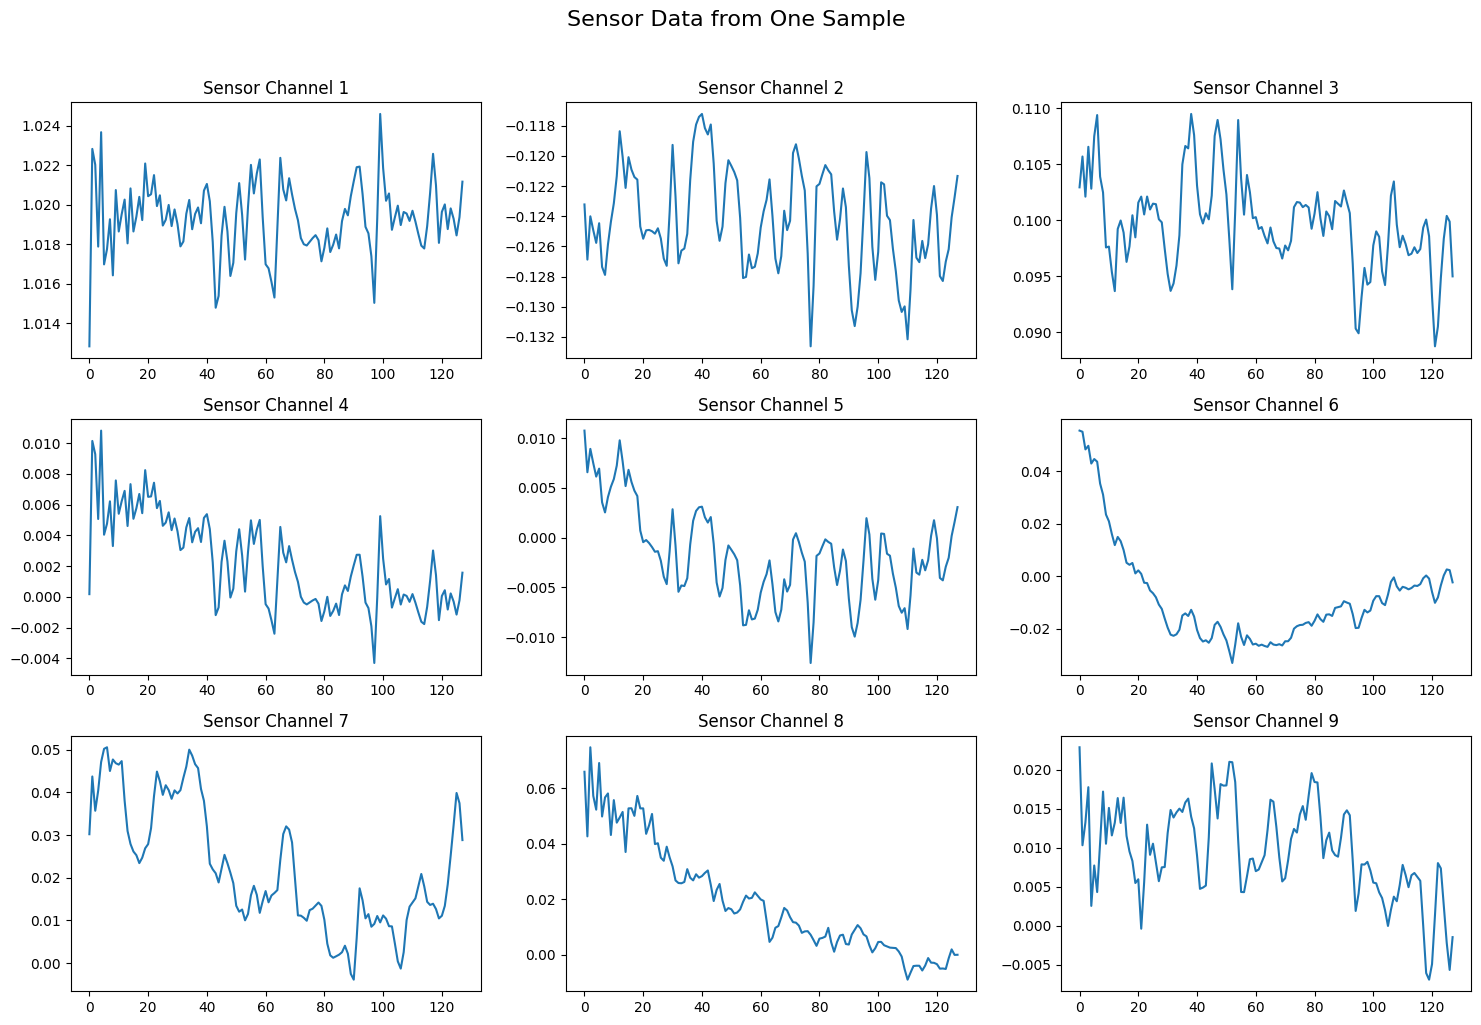

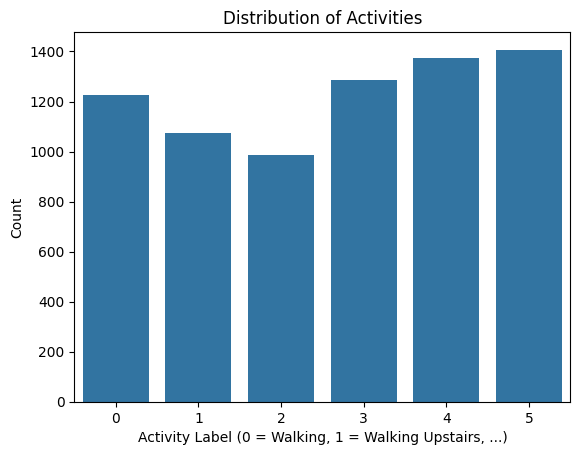

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a sample of the sensor data
sample_index = 0
plt.figure(figsize=(15, 10))
for i in range(X_train.shape[2]):
    plt.subplot(3, 3, i + 1)
    plt.plot(X_train[sample_index, :, i])
    plt.title(f"Sensor Channel {i+1}")
plt.suptitle("Sensor Data from One Sample", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Plot class distribution
original_labels = np.argmax(y_train, axis=1)
sns.countplot(x=original_labels)
plt.title("Distribution of Activities")
plt.xlabel("Activity Label (0 = Walking, 1 = Walking Upstairs, ...)")
plt.ylabel("Count")
plt.show()


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(2))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,498 (306.63 KB)

 Trainable params: 78,498 (306.63 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.4509 - loss: 1.2790 - val_accuracy: 0.6583 - val_loss: 0.7229
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.7428 - loss: 0.6043 - val_accuracy: 0.7516 - val_loss: 0.6994
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.7555 - loss: 0.6560 - val_accuracy: 0.7991 - val_loss: 0.5749
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.8792 - loss: 0.3293 - val_accuracy: 0.8439 - val_loss: 0.5283
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9074 - loss: 0.2466 - val_accuracy: 0.8517 - val_loss: 0.5110
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.9253 - loss: 0.2110 - val_accuracy: 0.8738 - val_loss: 0.4466
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9425 - loss: 0.1578 - val_accuracy: 0.8772 - val_loss: 0.4416
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9275 - loss: 0

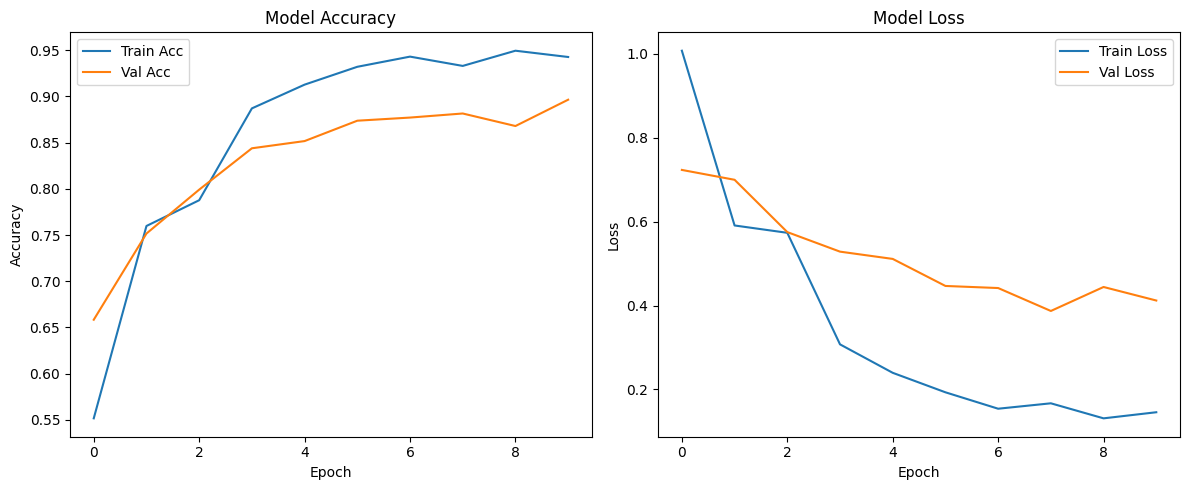

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8502 - loss: 0.5197
Test Accuracy: 89.65%


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       496
           1       0.87      0.92      0.89       471
           2       0.94      0.95      0.94       420
           3       0.81      0.81      0.81       491
           4       0.86      0.82      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



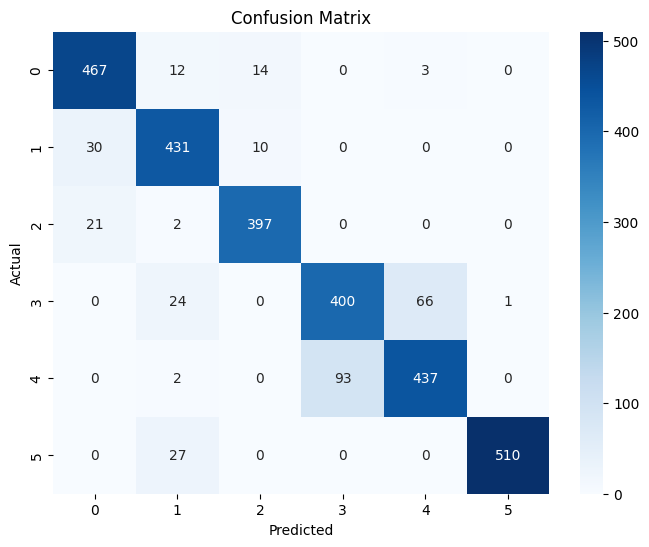

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
